In [2]:
import pandas as pd
import sqlite3
csv_data = pd.read_csv('bike_buyers.csv')
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
cursor.execute('''
CREATE TABLE Customer (
    CustomerID INTEGER PRIMARY KEY,
    Gender TEXT,
    MaritalStatus TEXT,
    Income INTEGER,
    Children INTEGER,
    Education TEXT,
    Occupation TEXT,
    HomeOwnerFlag INTEGER,
    NumberCarsOwned INTEGER,
    Age INTEGER
);
''')
cursor.execute('''
CREATE TABLE Location (
    LocationID INTEGER PRIMARY KEY AUTOINCREMENT,
    Region TEXT UNIQUE
);
''')
cursor.execute('''
CREATE TABLE CommuteDistance (
    CommuteDistanceID INTEGER PRIMARY KEY AUTOINCREMENT,
    Distance TEXT UNIQUE
);
''')
cursor.execute('''
CREATE TABLE BikePurchase (
    PurchaseID INTEGER PRIMARY KEY AUTOINCREMENT,
    CustomerID INTEGER,
    LocationID INTEGER,
    CommuteDistanceID INTEGER,
    PurchasedBike INTEGER,
    FOREIGN KEY (CustomerID) REFERENCES Customer(CustomerID),
    FOREIGN KEY (LocationID) REFERENCES Location(LocationID),
    FOREIGN KEY (CommuteDistanceID) REFERENCES CommuteDistance(CommuteDistanceID)
);
''')
for region in csv_data['Region'].dropna().unique():
    cursor.execute('INSERT INTO Location (Region) VALUES (?)', (region,))
for distance in csv_data['Commute Distance'].dropna().unique():
    cursor.execute('INSERT INTO CommuteDistance (Distance) VALUES (?)', (distance,))
for _, row in csv_data.iterrows():
    cursor.execute('''
    INSERT INTO Customer (CustomerID, Gender, MaritalStatus, Income, Children, Education, Occupation, HomeOwnerFlag, NumberCarsOwned, Age)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        row['ID'],
        row['Gender'],
        row['Marital Status'],
        row['Income'],
        row['Children'],
        row['Education'],
        row['Occupation'],
        1 if row['Home Owner'] == 'Yes' else 0,
        row['Cars'],
        row['Age']
    ))
for _, row in csv_data.iterrows():
    cursor.execute('''
    INSERT INTO BikePurchase (CustomerID, LocationID, CommuteDistanceID, PurchasedBike)
    VALUES (
        ?,
        (SELECT LocationID FROM Location WHERE Region = ?),
        (SELECT CommuteDistanceID FROM CommuteDistance WHERE Distance = ?),
        ?
    )
    ''', (
        row['ID'],
        row['Region'],
        row['Commute Distance'],
        1 if row['Purchased Bike'] == 'Yes' else 0
    ))
conn.commit()
print("Row counts:")
print("Customer:", cursor.execute('SELECT COUNT(*) FROM Customer').fetchone()[0])
print("Location:", cursor.execute('SELECT COUNT(*) FROM Location').fetchone()[0])
print("CommuteDistance:", cursor.execute('SELECT COUNT(*) FROM CommuteDistance').fetchone()[0])
print("BikePurchase:", cursor.execute('SELECT COUNT(*) FROM BikePurchase').fetchone()[0])




Row counts:
Customer: 1000
Location: 3
CommuteDistance: 5
BikePurchase: 1000


In [3]:
import pandas as pd
query = """
SELECT 
    c.CustomerID, c.Gender, c.MaritalStatus, c.Income, c.Children, c.Education, c.Occupation, 
    c.HomeOwnerFlag, c.NumberCarsOwned, c.Age, 
    l.Region, 
    cd.Distance AS CommuteDistance, 
    bp.PurchasedBike
FROM 
    Customer c
JOIN 
    BikePurchase bp ON c.CustomerID = bp.CustomerID
JOIN 
    Location l ON bp.LocationID = l.LocationID
JOIN 
    CommuteDistance cd ON bp.CommuteDistanceID = cd.CommuteDistanceID;
"""
df = pd.read_sql_query(query, conn)
print(df.head())

   CustomerID  Gender MaritalStatus   Income  Children        Education  \
0       12496  Female       Married  40000.0       1.0        Bachelors   
1       24107    Male       Married  30000.0       3.0  Partial College   
2       14177    Male       Married  80000.0       5.0  Partial College   
3       24381    None        Single  70000.0       0.0        Bachelors   
4       25597    Male        Single  30000.0       0.0        Bachelors   

       Occupation  HomeOwnerFlag  NumberCarsOwned   Age   Region  \
0  Skilled Manual              1              0.0  42.0   Europe   
1        Clerical              1              1.0  43.0   Europe   
2    Professional              0              2.0  60.0   Europe   
3    Professional              1              1.0  41.0  Pacific   
4        Clerical              0              0.0  36.0   Europe   

  CommuteDistance  PurchasedBike  
0       0-1 Miles              0  
1       0-1 Miles              0  
2       2-5 Miles              0  


In [4]:
purchase_distribution = csv_data['Purchased Bike'].value_counts(normalize=True)
print(purchase_distribution)


Purchased Bike
No     0.519
Yes    0.481
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(csv_data, test_size=0.2, stratify=csv_data['Purchased Bike'], random_state=42)


In [6]:
train_distribution = train_df['Purchased Bike'].value_counts(normalize=True)
test_distribution = test_df['Purchased Bike'].value_counts(normalize=True)

print("Training set distribution:")
print(train_distribution)
print("\nTest set distribution:")
print(test_distribution)


Training set distribution:
Purchased Bike
No     0.51875
Yes    0.48125
Name: proportion, dtype: float64

Test set distribution:
Purchased Bike
No     0.52
Yes    0.48
Name: proportion, dtype: float64


In [7]:
import pandas as pd
df = pd.read_csv('bike_buyers.csv')
info = df.info()
print(info)
summary_stats = df.describe()
print(summary_stats)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB
None
                 ID         Income    Children        Cars         Age
count   1000.000000     994.000000  992.000000  9

In [8]:
missing_values = df.isnull().sum()
print(missing_values)


ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64


In [9]:
unique_values = {col: df[col].nunique() for col in df.select_dtypes(include=['object']).columns}
print(unique_values)


{'Marital Status': 2, 'Gender': 2, 'Education': 5, 'Occupation': 5, 'Home Owner': 2, 'Commute Distance': 5, 'Region': 3, 'Purchased Bike': 2}


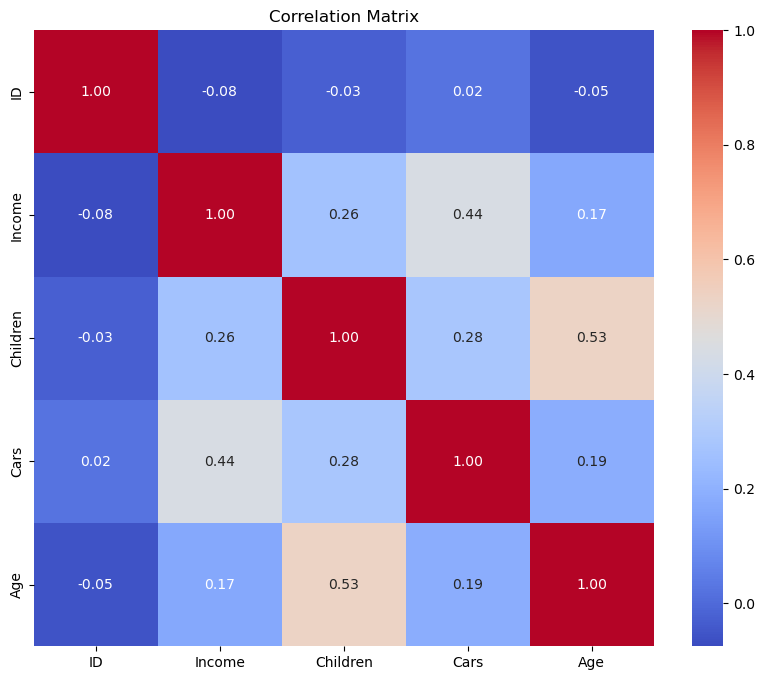

In [10]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



In [11]:
data_cleanup_tasks = [
    "Handle missing values in 'Marital Status', 'Gender', 'Income', 'Children', 'Cars', and 'Age' columns.",
    "Consider imputing missing values for numerical columns ('Income', 'Children', 'Cars', 'Age') using mean or median.",
    "For categorical columns ('Marital Status', 'Gender', 'Home Owner'), impute missing values using the mode.",
    "Check for outliers in 'Income', 'Age', 'Children', and 'Cars' columns and decide whether to cap or transform them.",
    "Encode categorical variables ('Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Purchased Bike') for modeling.",
    "Normalize or scale numerical features ('Income', 'Children', 'Cars', 'Age') to ensure consistent ranges.",
    "Verify that all columns have appropriate data types for analysis and modeling."
]
print(data_cleanup_tasks)


["Handle missing values in 'Marital Status', 'Gender', 'Income', 'Children', 'Cars', and 'Age' columns.", "Consider imputing missing values for numerical columns ('Income', 'Children', 'Cars', 'Age') using mean or median.", "For categorical columns ('Marital Status', 'Gender', 'Home Owner'), impute missing values using the mode.", "Check for outliers in 'Income', 'Age', 'Children', and 'Cars' columns and decide whether to cap or transform them.", "Encode categorical variables ('Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Purchased Bike') for modeling.", "Normalize or scale numerical features ('Income', 'Children', 'Cars', 'Age') to ensure consistent ranges.", 'Verify that all columns have appropriate data types for analysis and modeling.']


In [12]:
df['Income'] = df['Income'].fillna(df['Income'].median())
df['Children'] = df['Children'].fillna(df['Children'].median())
df['Cars'] = df['Cars'].fillna(df['Cars'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Marital Status'] = df['Marital Status'].fillna(df['Marital Status'].mode()[0])
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('bike_buyers.csv')
numerical_cols = ['Income', 'Children', 'Cars', 'Age']
categorical_cols = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df['Purchased Bike'] = df['Purchased Bike'].map({'Yes': 1, 'No': 0})
X = df.drop(columns=['Purchased Bike'])
y = df['Purchased Bike']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
import numpy as np
log_transformer = FunctionTransformer(np.log1p, validate=True)
numerical_transformer = Pipeline(steps=[
    ('log', log_transformer),
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])


In [15]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
print(f"Cross-Validation F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation F1-Score: 0.5893 ± 0.0627


In [16]:
from sklearn.metrics import f1_score, confusion_matrix
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"Test Set F1-Score: {f1:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


Test Set F1-Score: 0.5792
Confusion Matrix: TP=53, TN=70, FP=34, FN=43


In [17]:
import os
MLFLOW_TRACKING_URI="https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'Saaketh0910'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '087b6ac4d822342dadd8787c5ac10d23ecfec8a5'
import mlflow
from mlflow.models import infer_signature
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Bike Buyers Experiment 1")
with mlflow.start_run():
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("log_transform", True)
    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)
    mlflow.sklearn.log_model(pipeline, "model")

2024/12/21 22:38:48 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2024/12/21 22:38:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run adorable-crab-734 at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/7/runs/9e0c18166a46450692ad65eb8645157c
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/7


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")


Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best Cross-Validation F1-Score: 0.6015


In [19]:
with mlflow.start_run():
    for param_name in grid_search.best_params_:
        mlflow.log_param(param_name, grid_search.best_params_[param_name])
    mlflow.log_metric("best_cv_f1", grid_search.best_score_)

🏃 View run crawling-colt-441 at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/7/runs/35c05d3cb9584c24aead35498c7501fc
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/7


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('bike_buyers.csv')
df['Purchased Bike'] = df['Purchased Bike'].map({'Yes': 1, 'No': 0})
X = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np
numeric_features = ['Income', 'Children', 'Cars', 'Age']
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
log_transformer = FunctionTransformer(np.log1p, validate=True)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', log_transformer),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'RidgeClassifier': RidgeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier()
}
for name, classifier in classifiers.items():
    print(f"{name}: {classifier}")

LogisticRegression: LogisticRegression()
RidgeClassifier: RidgeClassifier()
RandomForestClassifier: RandomForestClassifier()
XGBClassifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [22]:
def train_and_evaluate(classifier, X, y):
    cv_scores = cross_val_score(classifier, X, y, cv=3, scoring='f1')
    classifier.fit(X, y)
    y_pred = classifier.predict(X)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return cv_scores, f1, tn, fp, fn, tp

In [23]:
pip install scikit-learn==1.4.0

Note: you may need to restart the kernel to use updated packages.


In [24]:
results = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    results[name] = train_and_evaluate(pipeline, X, y)

In [25]:
mlflow.set_tracking_uri("https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow")
mlflow.set_experiment("Bike Buyers Experiment 2")
for name, (cv_scores, f1, tn, fp, fn, tp) in results.items():
    with mlflow.start_run(run_name=name):
        mlflow.log_param("model", name)
        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("train_f1", f1)
        mlflow.log_metric("TN", tn)
        mlflow.log_metric("FP", fp)
        mlflow.log_metric("FN", fn)
        mlflow.log_metric("TP", tp)
        mlflow.sklearn.log_model(classifiers[name], "model")

2024/12/21 22:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8/runs/2da95d564e894801a592927de2ccea0a
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8


2024/12/21 22:39:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8/runs/2e983a80bb534f2bb95909323968b4d6
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8


2024/12/21 22:39:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8/runs/9bc1afe426db4777ae2784b203f2d04f
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8


2024/12/21 22:40:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8/runs/945ac4f261844083b6bb8a9ee9fd7f96
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/8


In [26]:
df = pd.read_csv('bike_buyers.csv')
def age_group(age):
    if age < 30:
        return 'Young'
    elif age < 50:
        return 'Middle-aged'
    else:
        return 'Senior'
df['AgeGroup'] = df['Age'].apply(age_group)

In [27]:
def life_stage(age, children):
    if age < 30 and children == 0:
        return 'Young Single'
    elif age < 50 and children > 0:
        return 'Family'
    elif age >= 50 and children == 0:
        return 'Empty Nester'
    else:
        return 'Other'
df['LifeStage'] = df.apply(lambda x: life_stage(x['Age'], x['Children']), axis=1)

In [28]:
df['IncomeBracket'] = pd.qcut(df['Income'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
df['EduOccupation'] = df['Education'] + '_' + df['Occupation']
df['HasCar'] = (df['Cars'] > 0).astype(int)
df['MaritalGender'] = df['Marital Status'] + '_' + df['Gender']
df['RegionCommute'] = df['Region'] + '_' + df['Commute Distance']

In [29]:
print(df.isnull().sum())
print(df.isnull().values.any())
df = df.dropna()
X = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
print(X.isnull().sum())

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
AgeGroup             0
LifeStage            0
IncomeBracket        6
EduOccupation        0
HasCar               0
MaritalGender       18
RegionCommute        0
dtype: int64
True
ID                  0
Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
AgeGroup            0
LifeStage           0
IncomeBracket       0
EduOccupation       0
HasCar              0
MaritalGender       0
RegionCommute       0
dtype: int64


In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Purchased Bike'] = le.fit_transform(df['Purchased Bike'])
numeric_features = ['Income', 'Children', 'Cars', 'Age']
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'AgeGroup', 'LifeStage', 'IncomeBracket', 'EduOccupation', 'HasCar', 'MaritalGender', 'RegionCommute']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
X = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
cv_scores = cross_val_score(rf_pipeline, X, y, cv=3, scoring='f1')
rf_pipeline.fit(X, y)
y_pred = rf_pipeline.predict(X)
f1 = f1_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

In [31]:
print(f"Cross-Validation F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Train F1-Score: {f1:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

Cross-Validation F1-Score: 0.6563 ± 0.0413
Train F1-Score: 0.9912
Confusion Matrix: TP=452, TN=492, FP=4, FN=4


In [32]:
mlflow.set_tracking_uri("https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow")
mlflow.set_experiment("Bike Buyers Experiment 3")
with mlflow.start_run():
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("imputation", "median for numeric, constant for categorical")
    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    mlflow.log_metric("train_f1", f1)
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)

🏃 View run persistent-bug-591 at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/9/runs/e483835464ff4942bbae4581656ad33c
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/9


In [33]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
X = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
X_encoded = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
corr_matrix = np.abs(np.corrcoef(X_scaled.T))
corr_threshold = 0.8
high_corr_features = set()
for i in range(len(corr_matrix)):
    for j in range(i):
        if corr_matrix[i, j] > corr_threshold:
            high_corr_features.add(X_encoded.columns[i])
X_corr_selected = X_encoded.drop(columns=high_corr_features)

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded, y)
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X_encoded.columns).sort_values(ascending=False)
top_features = feature_importances.head(10).index
X_importance_selected = X_encoded[top_features]

In [35]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.1)
X_var_selected = selector.fit_transform(X_scaled)
selected_features = X_encoded.columns[selector.get_support()]

In [36]:
import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri("https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow")
mlflow.set_experiment("Bike Buyers Experiment 4")
with mlflow.start_run():
    mlflow.log_param("correlation_threshold", corr_threshold)
    mlflow.log_metric("corr_selected_features", X_corr_selected.shape[1])
    mlflow.log_param("importance_top_n", 10)
    mlflow.log_metric("importance_selected_features", X_importance_selected.shape[1])
    mlflow.log_param("variance_threshold", 0.1)
    mlflow.log_metric("variance_selected_features", X_var_selected.shape[1])
    mlflow.log_dict({"corr_selected_features": X_corr_selected.columns.tolist()}, "corr_selected_features.json")
    mlflow.log_dict({"importance_selected_features": top_features.tolist()}, "importance_selected_features.json")
    mlflow.log_dict({"variance_selected_features": selected_features.tolist()}, "variance_selected_features.json")
    mlflow.log_dict(feature_importances.to_dict(), "feature_importances.json")

🏃 View run smiling-gull-21 at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/2/runs/148dc2b7264b4ed38b856c7abbdee045
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/2


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
df = pd.read_csv('bike_buyers.csv')
X = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
print(X.isnull().sum())
X_dropped = X.dropna()
print(X_dropped.isnull().sum())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

ID                               0
Income                           6
Children                         8
Cars                             9
Age                              8
Marital Status_Single            0
Gender_Male                      0
Education_Graduate Degree        0
Education_High School            0
Education_Partial College        0
Education_Partial High School    0
Occupation_Management            0
Occupation_Manual                0
Occupation_Professional          0
Occupation_Skilled Manual        0
Home Owner_Yes                   0
Commute Distance_1-2 Miles       0
Commute Distance_10+ Miles       0
Commute Distance_2-5 Miles       0
Commute Distance_5-10 Miles      0
Region_North America             0
Region_Pacific                   0
dtype: int64
ID                               0
Income                           0
Children                         0
Cars                             0
Age                              0
Marital Status_Single            0
Gender_

In [39]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

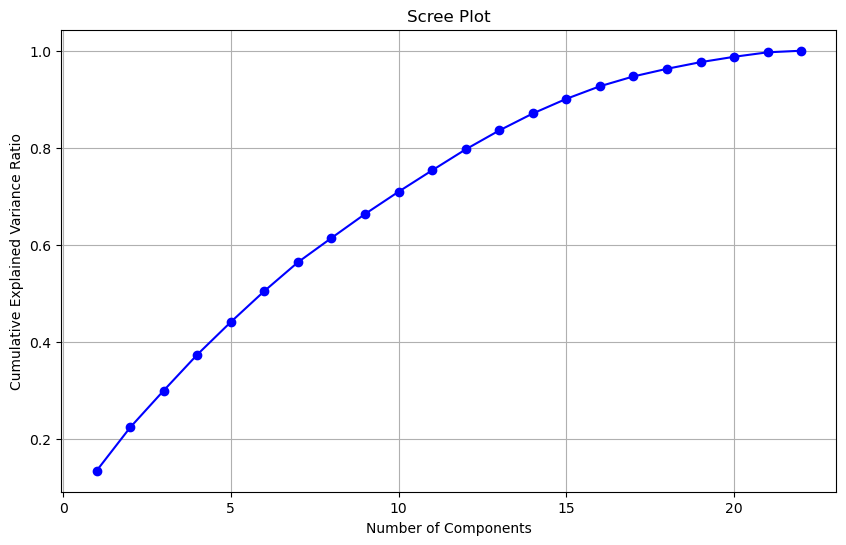

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

In [41]:
mlflow.set_experiment("Bike Buyers Experiment 5")
with mlflow.start_run():
    mlflow.log_param("n_components", n_components)
    mlflow.log_param("explained_variance_ratio", pca_final.explained_variance_ratio_.sum())
    plt.savefig("scree_plot.png")
    mlflow.log_artifact("scree_plot.png")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': pca_final.components_[0]
    }).sort_values('importance', ascending=False)
    mlflow.log_dict(feature_importance.to_dict(), "feature_importances.json")
    mlflow.sklearn.log_model(pca_final, "pca_model")

2024/12/21 22:40:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/21 22:40:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dazzling-ape-652 at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/3/runs/09e45766838c4be381f9026be56c80b5
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/3


<Figure size 640x480 with 0 Axes>

In [73]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('bike_buyers.csv')
df['Income_to_Children_Ratio'] = df['Income'] / (df['Children'] + 1)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Senior'])
numeric_features = ['Income', 'Children', 'Cars', 'Age', 'Income_to_Children_Ratio']
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Age_Group']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
le = LabelEncoder()
df['Purchased Bike'] = le.fit_transform(df['Purchased Bike'])
X = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
X = X.loc[y.index]
print(X.shape[0], y.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
feature_names = (numeric_features +
                 preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())

1000 1000


In [75]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
num_imputer = SimpleImputer(strategy='median')
X_train_imputed_num = num_imputer.fit_transform(X_train_preprocessed)
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed_cat = cat_imputer.fit_transform(X_train_preprocessed)
X_train_imputed = np.hstack((X_train_imputed_num, X_train_imputed_cat))
num_impute = SimpleImputer(strategy='median')
X_test_imputed_num = num_impute.fit_transform(X_test_preprocessed)
cat_impute = SimpleImputer(strategy='most_frequent')
X_test_imputed_cat = cat_impute.fit_transform(X_test_preprocessed)
X_test_imputed = np.hstack((X_test_imputed_num, X_test_imputed_cat))
selector = SelectKBest(mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train_imputed, y_train)
X_test_selected = selector.transform(X_test_imputed)
selected_features = [feature for feature, selected in zip(feature_names, selector.get_support()) if selected]
feature_names = selected_features
selected_features = [feature for feature, selected in zip(feature_names, selector.get_support()) if selected]

In [77]:
print(np.isnan(y_train).any())
print(np.isnan(y_train).sum())

False
0


In [79]:
from sklearn.ensemble import StackingClassifier
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]
meta_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=RandomForestClassifier(),
    cv=5
)
stacking_clf.fit(X_train_selected, y_train)
for name, estimator in stacking_clf.named_estimators_.items():
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_
        for feature, importance in zip(selected_features, importances):
            mlflow.log_metric(f"{name}_feature_importance_{feature}", importance)
    elif hasattr(estimator, 'coef_'):
        coefs = estimator.coef_[0]
        for feature, coef in zip(selected_features, coefs):
            mlflow.log_metric(f"{name}_feature_coefficient_{feature}", abs(coef))
if hasattr(stacking_clf.final_estimator_, 'feature_importances_'):
    meta_importances = stacking_clf.final_estimator_.feature_importances_
    for i, importance in enumerate(meta_importances):
        mlflow.log_metric(f"meta_model_importance_{i}", importance)
cv_scores = cross_val_score(stacking_clf, X_train_selected, y_train, cv=5, scoring='f1')
mlflow.log_metric("cv_f1_mean", cv_scores.mean())
mlflow.log_metric("cv_f1_std", cv_scores.std())
y_pred = stacking_clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mlflow.log_metric("test_accuracy", accuracy)
mlflow.log_metric("test_f1", f1)

In [81]:
from sklearn.ensemble import StackingClassifier
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]
meta_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=RandomForestClassifier(),
    cv=5
)
stacking_clf.fit(X_train_selected, y_train)
y_pred = stacking_clf.predict(X_test_selected)
for name, estimator in stacking_clf.named_estimators.items():
    if hasattr(estimator, 'feature_importances_'):
        for feature, importance in zip(feature_names, estimator.feature_importances_):
            mlflow.log_metric(f"{name}_feature_importance_{feature}", importance)
for name, estimator in stacking_clf.named_estimators.items():
    if hasattr(estimator, 'coef_'):
        for feature, coef in zip(feature_names, estimator.coef_[0]):
            mlflow.log_metric(f"{name}_feature_coefficient_{feature}", abs(coef))

In [83]:
mlflow.set_tracking_uri("https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow")
mlflow.set_experiment("Bike Buyers Experiment 6")
with mlflow.start_run(nested=True):
    stacking_clf.fit(X_train_selected, y_train)
    y_pred = stacking_clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mlflow.log_param("model", "Stacking Classifier")
    mlflow.log_param("base_models", ["RandomForest", "XGBoost", "LogisticRegression"])
    mlflow.log_param("meta_model", "GradientBoostingClassifier")
    mlflow.log_param("feature_engineering", True)
    mlflow.log_param("selected_features", selected_features)
    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_f1", f1)
    mlflow.sklearn.log_model(stacking_clf, "stacking_classifier")

2024/12/21 22:56:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sneaky-conch-295 at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/4/runs/2f424231f5ba48b78a6a39964fc20c8b
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/4


In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('bike_buyers.csv')
le = LabelEncoder()
df['Purchased Bike'] = le.fit_transform(df['Purchased Bike'])
df = df.dropna()
df['Income_to_Age_Ratio'] = df['Income'] / (df['Age'] + 1)
df['Cars_per_Child'] = df['Cars'] / (df['Children'] + 1)
numeric_features = ['Income', 'Children', 'Cars', 'Age', 'Income_to_Age_Ratio', 'Cars_per_Child']
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])
X = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('lgb', LGBMClassifier(random_state=42))
]
meta_model = LogisticRegression()
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', stacking_clf)
])
param_space = {
    'classifier__rf__n_estimators': [50, 100, 200],
    'classifier__rf__max_depth': [5, 10, None],
    'classifier__xgb__n_estimators': [50, 100, 200],
    'classifier__xgb__max_depth': [3, 5, 7],
    'classifier__lgb__n_estimators': [50, 100, 200],
    'classifier__lgb__num_leaves': [31, 63, 127],
    'classifier__final_estimator__C': [0.1, 1.0, 10.0]
}
random_search = RandomizedSearchCV(
    pipeline, param_space, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)
X_transformed = random_search.transform(X_test)
mlflow.set_tracking_uri("https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow")
mlflow.set_experiment("Bike Buyers Experiment 7")
with mlflow.start_run(nested=True):  
    mlflow.log_params(random_search.best_params_)
    y_pred = random_search.predict(X_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    cv_scores = cross_val_score(random_search.best_estimator_, X, y, cv=5, scoring='f1')
    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    mlflow.sklearn.log_model(random_search.best_estimator_, "stacking_ensemble_model")
print("Best parameters:", random_search.best_params_)
print("Test Accuracy:", accuracy)
print("Test F1-score:", f1)
print("Cross-validation F1-score: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470434 -> initscore=-0.118404
[LightGBM] [Info] Start training from score -0.118404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

ValueError: X has 3 features, but ColumnTransformer is expecting 14 features as input.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = {
    'Experiment': ['Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5', 'Exp6', 'Exp7'],
    'F1_Score': [0.589, 0.540, 0.656, 0.649, 0.649, 0.70, 0.649]
}
df = pd.DataFrame(data)

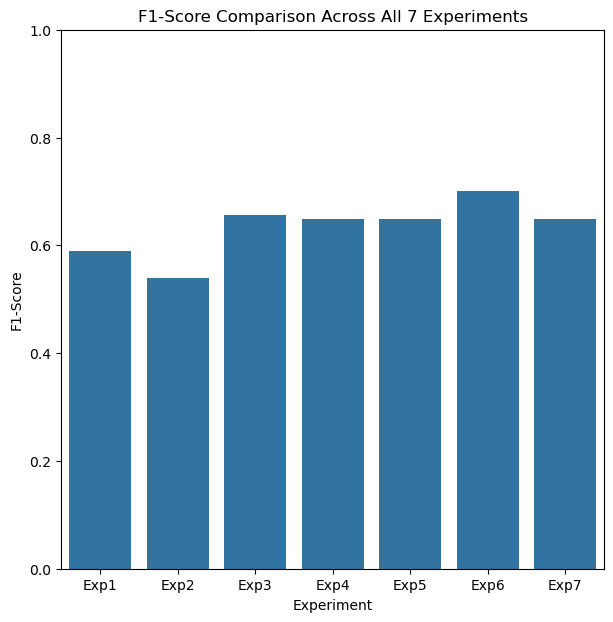

In [52]:
plt.figure(figsize=(7, 7))
sns.barplot(x='Experiment', y='F1_Score', data=df)
plt.title('F1-Score Comparison Across All 7 Experiments')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.savefig('f1_score_comparison_all_experiments.png')

In [53]:
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow")
mlflow.set_experiment("Comparing F1score plots")

with mlflow.start_run(nested=True):
    mlflow.log_artifact('f1_score_comparison_all_experiments.png')

🏃 View run beautiful-pug-898 at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/6/runs/f9d278b06db44bb093e911261628a2c1
🧪 View experiment at: https://dagshub.com/Saaketh0910/ML_Final_Project.mlflow/#/experiments/6


In [89]:
import joblib
joblib.dump(stacking_clf, 'bike_buyers_model.joblib')
print("Model saved as 'bike_buyers_model.joblib'")

Model saved as 'bike_buyers_model.joblib'


In [91]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np
@st.cache_resource
def load_model():
    return joblib.load('bike_buyers_model.joblib')
model = load_model()
st.title('Bike Buyers Prediction')
income = st.number_input('Income', min_value=0)
children = st.number_input('Number of Children', min_value=0, max_value=10, step=1)
cars = st.number_input('Number of Cars', min_value=0, max_value=10, step=1)
age = st.number_input('Age', min_value=0, max_value=120, step=1)
marital_status = st.selectbox('Marital Status', ['Single', 'Married'])
gender = st.selectbox('Gender', ['Male', 'Female'])
education = st.selectbox('Education', ['High School', 'Partial College', 'Bachelors', 'Graduate Degree'])
occupation = st.selectbox('Occupation', ['Manual', 'Skilled Manual', 'Clerical', 'Professional', 'Management'])
home_owner = st.selectbox('Home Owner', ['Yes', 'No'])
commute_distance = st.selectbox('Commute Distance', ['0-1 Miles', '1-2 Miles', '2-5 Miles', '5-10 Miles', '10+ Miles'])
region = st.selectbox('Region', ['Europe', 'Pacific', 'North America'])
if st.button('Predict'):
    try:
        input_data = pd.DataFrame({
            'Income': [income],
            'Children': [children],
            'Cars': [cars],
            'Age': [age],
            'Marital Status': [marital_status],
            'Gender': [gender],
            'Education': [education],
            'Occupation': [occupation],
            'Home Owner': [home_owner],
            'Commute Distance': [commute_distance],
            'Region': [region]
        })
        prediction = model.predict(input_data)
        prediction_proba = model.predict_proba(input_data)
        st.write('Prediction:', 'Will buy a bike' if prediction[0] == 1 else 'Will not buy a bike')
        st.write(f'Probability of buying a bike: {prediction_proba[0][1]:.2f}')
    except Exception as e:
        st.error(f"An error occurred: {str(e)}")
st.markdown("""
## About this app
This app predicts whether a person is likely to buy a bike based on various features.
Enter the required information and click 'Predict' to see the result.
""")

2024-12-21 23:06:43.182 
  command:

    streamlit run C:\Users\Admin\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()